In [6]:
import numpy as np
import pandas as pd

from scipy.integrate import solve_ivp

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

np.set_printoptions(precision=5)
pd.set_option("display.precision", 5)
palette = 'mako'

sns.set_palette(palette)
pal = sns.color_palette(palette)

nr_resources = 5
nr_bacteria = 5
nr_phages = 5
M = 3
cutoff_value = 0.000001
nr_of_serial_transfers = 5
simulation_length = 24
serial_transfer_value = 15
serial_transfer_option = True
Initial_N = [np.random.random()*500 for i in range(nr_resources)]
Initial_U = [np.random.random()*500 for i in range(nr_bacteria)]
Initial_I = [0 for i in range(nr_bacteria*M)]
Initial_P = [np.random.random()*500 for i in range(nr_phages)]
initial_condition = Initial_N + Initial_U + Initial_I + Initial_P 
initial_condition_for_serial_transfer = initial_condition.copy()
initial_condition_names_for_serial_transfer = ['N'for i in range(nr_resources)] + ['U' for i in range(nr_bacteria)] + ['I' for i in range(nr_bacteria*M)] + ['P' for i in range(nr_phages)]

e_vector = np.random.uniform(0, 1, nr_resources)
tau_vector = np.random.uniform(0, 1, nr_bacteria)
v_matrix = np.random.uniform(0, 1, (nr_bacteria, nr_resources))
K_matrix = np.random.uniform(0, 1, (nr_bacteria, nr_resources))
r_matrix = np.random.uniform(0, 1, (nr_phages, nr_bacteria))
B_matrix = np.random.uniform(0, 1, (nr_phages, nr_bacteria))

In [7]:
def odesystem(t, Y, *params):
    #TODO: look at biology side, try to replicate graphs
    #TODO: explore the model(s)
    # start simple, bacteria-resource, see how the bacteria and reosurces grow/shrink, bacteria should hit carrying capacity, nutrient should reach 0, not negative, etc
    phage_nodes, bacteria_nodes, nutrient_nodes, M, e_vector, tau_vector, v_matrix, K_matrix, r_matrix, B_matrix = params
    def g(N, v, K):
        return (N * v) / (N + K)

    Y = check_cutoff(Y, cutoff_value)
    
    N, U, I, P = unflatten_initial_matrix(Y, [len(nutrient_nodes), len(bacteria_nodes), (len(bacteria_nodes), M), len(phage_nodes)])
    new_N = np.zeros_like(N)
    new_U = np.zeros_like(U)
    new_I = np.zeros_like(I)
    new_P = np.zeros_like(P)
    #update N vector
    for nutrient in nutrient_nodes:
        n_index = nutrient_nodes.index(nutrient)
        e_value = e_vector[n_index] 
        sum_g = 0
        sum_u = 0
        sum_i = 0
        for bacteria in bacteria_nodes:
            b_index = bacteria_nodes.index(bacteria)
            if True: # graph.has_edge(bacteria, nutrient):
                v = v_matrix[b_index, n_index]
                K = K_matrix[b_index, n_index]
                sum_g += g(N[n_index], v, K)
                sum_u += U[b_index]
                sum_i += np.sum(I[b_index])
        new_N[n_index] = -(e_value * sum_g) * (sum_u + sum_i)
    
    # update U vector, i, and j are flipped relative to what is seen in update N vector for v, K, and r matrices because of how the row and columns are defined in the graph
    # dont sum U in left and right, because we are looking at an individual bacteria
    for uninfected in bacteria_nodes:
        u_index = bacteria_nodes.index(uninfected)
        g_sum = 0
        right = 0
        for nutrient in nutrient_nodes:
            n_index = nutrient_nodes.index(nutrient)
            if True: #graph.has_edge(uninfected, nutrient):
                g_sum += g(N[n_index], v_matrix[u_index, n_index], K_matrix[u_index, n_index])
        for phage in phage_nodes:
            p_index = phage_nodes.index(phage)
            if True: #graph.has_edge(phage, uninfected):
                right += r_matrix[p_index, u_index] * P[p_index]
        new_U[u_index] = g_sum * U[u_index] - right * U[u_index]

    for infected in bacteria_nodes:
        i_index = bacteria_nodes.index(infected)
        for infected_stage in range(0, M):
            if infected_stage == 0:
                left_sum = 0
                right_sum = 0
                for phage in phage_nodes:
                    p_index = phage_nodes.index(phage)
                    if True: # graph.has_edge(phage, infected):
                        left_sum += r_matrix[p_index, i_index] * P[p_index]
                        right_sum += M / tau_vector[i_index] * I[i_index, 0]
                new_I[i_index, 0] = left_sum * U[i_index] - right_sum
            else:
                m_tau = M / tau_vector[i_index]
                right = I[i_index, infected_stage - 1] - I[i_index, infected_stage]
                new_I[i_index, infected_stage] = m_tau * right
    
    for phage in phage_nodes:
        p_index = phage_nodes.index(phage)
        left_sum = 0
        right_sum = 0
        for infected in bacteria_nodes:
            i_index = bacteria_nodes.index(infected)
            if True: #graph.has_edge(phage, infected):
                left_sum += B_matrix[p_index, i_index] * M / tau_vector[i_index] * I[i_index, -1]
                right_sum += r_matrix[p_index, i_index] * (U[i_index] + np.sum(I[i_index])) * P[p_index]
        new_P[p_index] = left_sum - right_sum

    flattened_y1 = flatten_lists_and_matrices(new_N, new_U, new_I, new_P)
    return flattened_y1
    
def solve_system(ODE_system_function, y0_flattened:np.array, *ODE_system_parameters, t_start = None, t_end = None, **extra_parameters) -> np.array:
    if t_start is None:
        t_start = 0
    if t_end is None:
        t_end = 24
    solved = solve_ivp(ODE_system_function, (t_start, t_end), y0_flattened, args=ODE_system_parameters, **extra_parameters)
    return solved

def check_cutoff(flat_array:np.array, cutoff_value:float):
    for index, value in enumerate(flat_array):
        if value <= float(cutoff_value):
            flat_array[index] = 0
    return flat_array

def flatten_lists_and_matrices(*initial_populations:np.array) -> np.array:
    return np.concatenate([flat.flatten() for flat in initial_populations])

def unflatten_initial_matrix(vector:np.array, length) -> np.array:
    if isinstance(length, int):
        return np.array([vector[i:i+length] for i in range(0, len(vector), length)])
    elif isinstance(length, list):
        result = []
        index = 0
        for l in length:
            if type(l) == int:
                result.append(vector[index:index+l])
                index += l
            elif type(l) == tuple:
                result.append(np.array(vector[index:index+int(np.prod(l))]).reshape(l))
                index += int(np.prod(l))
        return result
    else:
        raise ValueError("Length must be an int or a list of ints")

def serial_transfer_calculation(original_final_simulation_output, serial_transfer_value, serial_tranfer_option, flattened, row_of_names):
    row_of_values = []
    if (serial_tranfer_option):
        return flattened + original_final_simulation_output / serial_transfer_value
    for final, name, flat in zip(original_final_simulation_output, row_of_names, flattened):
        if (name.lower() in ["resources", "resource", "r", "res", "r0", "nutrient", "nutrients", "n", "nut", "n0"]):
            row_of_values.append(flat + final / serial_transfer_value)
        else:
            row_of_values.append(final / serial_transfer_value)
    return row_of_values

def sum_up_rows(unflattened_data):
    new_unflattened_data = []
    for item in unflattened_data:
        if (len(item.shape) > 1):
            new_unflattened_data.append(np.sum(item, axis=1))
        else:
            new_unflattened_data.append(item)
    return new_unflattened_data

In [8]:
start_time = 0
end_time = simulation_length
list_of_end_conditions = []
list_of_end_times = []
for i in range(nr_of_serial_transfers):
    solved_system = solve_system(odesystem, initial_condition, *([Initial_P, Initial_U, Initial_N, M, e_vector, tau_vector, v_matrix, K_matrix, r_matrix, B_matrix]), t_start=start_time, t_eçnd=end_time)
    initial_condition = solved_system.y[:,-1]
    list_of_end_conditions.append(initial_condition)
    list_of_end_times.append(solved_system.t[-1])
    start_time = end_time
    end_time += simulation_length
    initial_condition = serial_transfer_calculation(initial_condition, serial_transfer_value, serial_transfer_option, initial_condition_for_serial_transfer, initial_condition_names_for_serial_transfer)
    

c:\Users\victo\AppData\Local\Programs\Python\Python313\Lib\site-packages\scipy\integrate\_ivp\ivp.py:621: UserWarning: The following arguments have no effect for a chosen solver: `t_eçnd`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


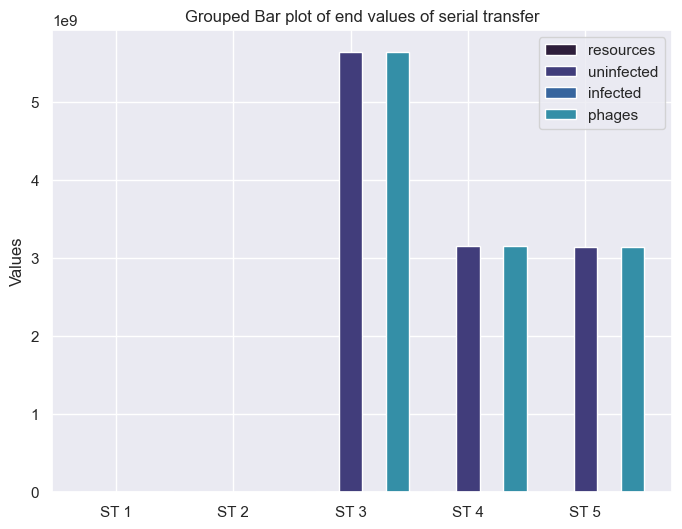

In [4]:
list_of_end_conditions_unflattened = []
averages = []

for i in range(len(list_of_end_conditions)):
    unflat = unflatten_initial_matrix(list_of_end_conditions[i], [nr_resources, nr_bacteria, (nr_bacteria, M), nr_phages])
    list_of_end_conditions_unflattened.append(sum_up_rows(unflat))
    averages.append([np.mean(group) for group in unflat])
num_groups = len(averages)
num_bars = len(averages[0])
x = np.arange(num_groups)
bar_width = 0.2
labels = ["resources", "uninfected", "infected", "phages"]
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(num_bars):
    ax.bar(x + i * bar_width, [group[i] for group in averages], width=bar_width, label=labels[i])
ax.set_xticks(x + bar_width)
ax.set_xticklabels([f"ST {i+1}" for i in range(num_groups)])
ax.set_ylabel("Values")
ax.set_title("Grouped Bar plot of end values of serial transfer")
ax.legend()

plt.show()